Import libraries


In [28]:
# import libraries
!pip install SimpleITK
!pip install opencv-python
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os
import random
import time
import shutil
import argparse
from multiprocessing.dummy import Pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from skimage.morphology import binary_opening, disk, label
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms




Change parameters here.

In [29]:

base_image_path = "../../Training2/"
base_label_path = "../../Label2/"
depth = 240
height = 240
width = 240
use_resize_2 = False

A helper function that reads in original labels and save as a list of labels used in validation.

In [30]:
def load_labels():
    labels = []
    for file in os.listdir(base_label_path):
        label = sitk.ReadImage(file)
        labelArray = sitk.GetArrayFromImage(label)
    return labels
    

Prepare data for training U-Net:
- Resize the image to be cubes of size 240x240x240
- (Optional)Normalize each image to in range(0,1) inclusively

In [31]:
#pass in 2D image
def normalization(img):
    newImg = (img-np.min(img))/(np.max(img)-np.min(img))
    return newImg

def data_prepare(path, is_label_data):

    heart = sitk.ReadImage(path)
    heartArray = sitk.GetArrayFromImage(heart)
    #print(heartArray.shape)

    # resize the image
    img_stack_sm = np.zeros((len(heartArray), height, depth))

    for idx in range(len(heartArray)):
        img = heartArray[idx, :, :]
        if is_label_data:
            img_sm = cv2.resize(img, (height, depth), interpolation=cv2.INTER_NEAREST)
        else:
            img_sm = cv2.resize(img, (height, depth), interpolation=cv2.INTER_CUBIC)
        img_stack_sm[idx, :, :] = img_sm

    if(use_resize_2):
        img_stack_sm2 = np.zeros((width, height, depth))

        for idx in range(height):
            img = img_stack_sm[:, idx, :]
            if is_label_data:
                img_sm = cv2.resize(img, (width, depth), interpolation=cv2.INTER_NEAREST)

            else:
                img_sm = cv2.resize(img, (width, depth), interpolation=cv2.INTER_CUBIC)
            img_stack_sm2[:, idx, :] = img_sm
        img_stack_sm = img_stack_sm2

    #print(img_stack_sm.shape)

    return img_stack_sm.tolist()

In [32]:
def get_data(figuresize):
    global depth
    global width
    global height
    
    depth = figuresize
    width = figuresize
    height = figuresize
    
    image = []
    label = []
    heart_index = []
    
    for file in os.listdir(base_image_path):
        if(file[0] == '.'):
            continue
        image_path = base_image_path+file
        label_path = base_label_path+file[:-4]+"-label.nii"
        print(image_path)
        print(label_path)

        image += (data_prepare(image_path, False))
        temp = data_prepare(label_path, True)
        heart_index.append((len(image), int(image_path[-5])))
        label += temp
    
    return np.expand_dims(np.array(image), axis=1).astype(np.float32), np.array(label), heart_index

def load_labels():
    labelshape = [0]*10
    for file in os.listdir(base_label_path):
        if(file[0] == '.'):
            continue
        print(file)
        label = sitk.ReadImage(base_label_path+file)
        labelArray = sitk.GetArrayFromImage(label)
        labelshape[int(file[-11])] = labelArray
    return labelshape

In [33]:
label_original = load_labels()
image, label, index = get_data(240)

training_axial_crop_pat4-label.nii
training_axial_crop_pat5-label.nii
training_axial_crop_pat6-label.nii
training_axial_crop_pat7-label.nii
training_axial_crop_pat0-label.nii
training_axial_crop_pat1-label.nii
training_axial_crop_pat2-label.nii
training_axial_crop_pat3-label.nii
training_axial_crop_pat9-label.nii
training_axial_crop_pat8-label.nii
../../Training2/training_axial_crop_pat4.nii
../../Label2/training_axial_crop_pat4-label.nii
../../Training2/training_axial_crop_pat3.nii
../../Label2/training_axial_crop_pat3-label.nii
../../Training2/training_axial_crop_pat2.nii
../../Label2/training_axial_crop_pat2-label.nii
../../Training2/training_axial_crop_pat5.nii
../../Label2/training_axial_crop_pat5-label.nii
../../Training2/training_axial_crop_pat6.nii
../../Label2/training_axial_crop_pat6-label.nii
../../Training2/training_axial_crop_pat1.nii
../../Label2/training_axial_crop_pat1-label.nii
../../Training2/training_axial_crop_pat8.nii
../../Label2/training_axial_crop_pat8-label.nii

Define unit convolutions that will be repeatedly called in the model.

In [34]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

Define the DownConv Module that 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.

In [35]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

Define the UpConv module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.

In [36]:
class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x


    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

In [37]:
class UNet(nn.Module):


    def __init__(self, num_classes, in_channels=1, depth=5,
                 start_filts=4, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

Define the dataset that will be passed to the dataloader to generate each training sample.
Note that the accuracy can be computed using 

In [45]:
class MyCustomDataset(Dataset):
    def __init__(self, type, dev_heart):
        if(dev_heart == 0):
            from_num = 0
        else:
            from_num = heart_index[dev_heart-1][0]
        to_num = heart_index[dev_heart][0]
        if(type == 'Train'):
            self.image = np.concatenate((total_image[:from_num,:,:,:],total_image[to_num:,:,:,:]))
            self.label = np.concatenate((total_label[:from_num,:,:],total_label[to_num:,:,:]))
            print(self.image.shape)
            print(self.label.shape)
        else:
            self.image = total_image[from_num:to_num, :, :, :]
            self.label = total_label[from_num:to_num, :, :]
            print(self.image.shape)
            print(self.label.shape)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        mask = self.label[idx]
        return (image, mask)

def get_loss(dl, model):
    loss = 0
    for X, y in dl:
        X, y = Variable(X).cuda(), Variable(y).cuda()
        output = model(X)
        # !! changed to .item() was 
        #loss += F.cross_entropy(output, y.long()).data[0]
        loss += F.cross_entropy(output, y.long()).item()
    loss = loss / len(dl)
    return loss


def one_hot(x, classes):
    #print(x.shape)
    #print(x.dtype)
    length = len(x)
    x_one_hot = np.zeros((classes, length))
    x_one_hot[x, np.arange(length)] = 1
    return x_one_hot


Define dice score and Jaccard score to evaluate accuracy.

In [46]:

'''
label: ground truth label matrix or tensor
target: predicted label matrix or tensor
classes: number of classes in the label
'''


def dice_score(label, target, classes):
    smooth = 1.

    label_cols = one_hot(label.flatten(), classes)
    target_cols = one_hot(target.flatten(), classes)

    intersection = np.sum((label_cols * target_cols), axis=1)  # len = classes
    normalization = np.sum((label_cols + target_cols), axis=1)  # len = classes

    #print(intersection)
    #print(normalization)

    return ((2. * intersection + smooth).sum() /
            (normalization + smooth).sum())


'''
label: predicted label matrix or tensor
target: predicted label matrix or tensor
classes: number of classes in the label
*WARNING: label and target must be of the same dimension. 
'''


def jaccard_index(label, target):
    label_flat = label.flatten()
    target_flat = target.flatten()
    length = len(label_flat)
    assert (length == len(target_flat))

    union = (label_flat != target_flat).astype(int).sum() + length
    intersection = (label_flat == target_flat).astype(int).sum()

    return intersection / union


def get_accuracy(dl, model):

    total_num = 0
    correct_num = 0

    for X, y in dl:
        X = Variable(X).cuda()
        output = model(X).cpu()
        #print(output.shape)
        #print(y.shape)
        #print(y.type())
        #print(np.argmax(output.data.numpy()).dtype)
        correct_num += (np.argmax(output.data.numpy(),axis=1) == y.data.numpy().astype("int64")).sum().item()
        total_num += y.shape[0]*y.shape[1]*y.shape[2]

    return correct_num/total_num

def get_dice_score(dl, model):

    #batch_num = 0
    score = 0
    #img_sm = cv2.resize(img, (height, depth), interpolation=cv2.INTER_NEAREST)

    for X, y in dl:
        X = Variable(X).cuda()
        output = model(X).cpu()
        #print(output.shape)
        predicted = np.argmax(output.data.numpy().astype("int64"),axis=1)
        #print(predicted.shape)

        predicted_origin = [0]*predicted.shape[0]
        for idx in range(len(predicted)):
            img = predicted[idx, :, :]
            img_sm = cv2.resize(img, (label_original[heart_index[dev_heart][1]].shape[2], label_original[heart_index[dev_heart][1]].shape[1]), interpolation=cv2.INTER_NEAREST)
            predicted_origin[idx] = img_sm
        predicted_origin = np.array(predicted_origin)

        #print(predicted_origin.shape)
        ground_truth = label_original[heart_index[dev_heart][1]].astype("int64")
        #print(ground_truth.shape)
        #score = dice_score(y.data.numpy().astype("int64"),np.argmax(output.data.numpy().astype("int64"),axis=1), 3)
        score = dice_score(ground_truth,predicted_origin, 3)
        #print(batch_num)
        #batch_num += 1

    return score

def get_jaccard_score(dl, model):

    score = 0
    for X, y in dl:
        X = Variable(X).cuda()
        output = model(X).cpu()
        #print(output.shape)
        predicted = np.argmax(output.data.numpy().astype("int64"),axis=1)
        #print(predicted.shape)

        predicted_origin = [0]*predicted.shape[0]
        for idx in range(len(predicted)):
            img = predicted[idx, :, :]
            img_sm = cv2.resize(img, (label_original[heart_index[dev_heart][1]].shape[2], label_original[heart_index[dev_heart][1]].shape[1]), interpolation=cv2.INTER_NEAREST)
            predicted_origin[idx] = img_sm
        predicted_origin = np.array(predicted_origin)

        #print(predicted_origin.shape)
        ground_truth = label_original[heart_index[dev_heart][1]].astype("int64")
        #print(ground_truth.shape)
        #score = dice_score(y.data.numpy().astype("int64"),np.argmax(output.data.numpy().astype("int64"),axis=1), 3)
        score = jaccard_index(ground_truth,predicted_origin)

    return score


Define parameters that will be used in the training routine

In [49]:
# parser = argparse.ArgumentParser(description='UNET Implementation')
# parser.add_argument('--batch-size', type=int, default=4, metavar='N',
#                     help='input batch size for training (default: 4)')
# parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                     help='input batch size for testing (default: 1000)')
# parser.add_argument('--epochs', type=int, default=20, metavar='N',
#                     help='number of epochs to train (default: 20)')
# parser.add_argument('--figuresize', type=int, default=240, metavar='N',
#                     help='size that we use for the model')
# parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
#                     help='learning rate (default: 0.001)')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=1, metavar='N',
#                     help='how many epoches between logging training status')
# parser.add_argument('--save-model', action='store_true', default=True,
#                     help='For Saving the current Model')
# parser.add_argument('--test-model', type=str, default='', metavar='N',
#                     help='If test-model has a name, do not do training, just testing on dev and train set')
# parser.add_argument('--load-model', type=str, default='', metavar='N',
#                     help='If load-model has a name, use pretrained model')
# args = parser.parse_args()

args = {
    "batch_size": 4,
    "test-batch-size": 1000,
    "epochs":50,
    "figuresize":240,
    "lr":0.001,
    "seed":1,
    "log_interval":1,
    "save_model":True,
    "test_model":"",
    "load_mode":""
}

total_image, total_label, heart_index = get_data(args["figuresize"])
dev_heart = 0
total_number_of_2Dfigure = 1497
timeStr = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
os.mkdir(timeStr + "model")

../../Training2/training_axial_crop_pat4.nii
../../Label2/training_axial_crop_pat4-label.nii
../../Training2/training_axial_crop_pat3.nii
../../Label2/training_axial_crop_pat3-label.nii
../../Training2/training_axial_crop_pat2.nii
../../Label2/training_axial_crop_pat2-label.nii
../../Training2/training_axial_crop_pat5.nii
../../Label2/training_axial_crop_pat5-label.nii
../../Training2/training_axial_crop_pat6.nii
../../Label2/training_axial_crop_pat6-label.nii
../../Training2/training_axial_crop_pat1.nii
../../Label2/training_axial_crop_pat1-label.nii
../../Training2/training_axial_crop_pat8.nii
../../Label2/training_axial_crop_pat8-label.nii
../../Training2/training_axial_crop_pat9.nii
../../Label2/training_axial_crop_pat9-label.nii
../../Training2/training_axial_crop_pat0.nii
../../Label2/training_axial_crop_pat0-label.nii
../../Training2/training_axial_crop_pat7.nii
../../Label2/training_axial_crop_pat7-label.nii


The training routine is defined below. Here are a few notes:
1. each 2d slices is randomly shuffled during training
2. An entire subject is left out for cross validation


In [50]:
while(dev_heart < 10):

    print("We are using heart "+str(heart_index[dev_heart][1]))
    train_loader = torch.utils.data.DataLoader(MyCustomDataset('Train', dev_heart), batch_size=args['batch_size'], shuffle=True)
    if (dev_heart == 0):
        dev_loader = torch.utils.data.DataLoader(MyCustomDataset('Dev', dev_heart), batch_size=heart_index[0][0], shuffle=False)
    else:
        dev_loader = torch.utils.data.DataLoader(MyCustomDataset('Dev', dev_heart), batch_size=heart_index[dev_heart][0]-heart_index[dev_heart-1][0], shuffle=False)

    model = UNet(3, merge_mode='concat')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model = model.to(device)
    model.train()

    best_dice = 0
    best_jaccard = 0
    optim = torch.optim.Adam(model.parameters(),lr=args['lr'])

    os.mkdir(timeStr + "model/dice"+str(heart_index[dev_heart][1]))
    os.mkdir(timeStr + "model/jaccard"+str(heart_index[dev_heart][1]))

    for epoch in range(args['epochs']):

        for batch_idx, (data, label) in enumerate(train_loader):

            data, target = data.to(device), label.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target.long())

            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % args['log_interval'] == 0:

            print("Epoch : "+str(epoch))
            model.eval()

            train_loss = get_loss(train_loader, model)
            print(train_loss)
            train_acc = get_accuracy(train_loader, model)
            dev_dice = get_dice_score(dev_loader, model)
            dev_jaccard = get_jaccard_score(dev_loader, model)
            dev_acc = get_accuracy(dev_loader, model)
            print("Training accuracy : " + str(train_acc))
            print("Dev dice score : " + str(dev_dice))
            print("Dev jaccard score : " + str(dev_jaccard))
            print("Dev accuracy : " + str(dev_acc))
            if(train_acc < 0.01):
                print("Bad initialization")
                exit(0)
            if(args['save_model'] and (dev_dice > best_dice)):
                torch.save(model.state_dict(), timeStr + "model/dice"+str(heart_index[dev_heart][1])+"/" + str(epoch) + ":" + str(dev_dice) + ".pt")
                best_dice = dev_dice
            if(args['save_model'] and (dev_jaccard > best_jaccard)):
                torch.save(model.state_dict(), timeStr + "model/jaccard"+str(heart_index[dev_heart][1])+"/" + str(epoch) + ":" + str(dev_jaccard) + ".pt")
                best_jaccard = dev_jaccard

            model.train()

    print("Done")

    dev_heart += 1

We are using heart 4
(1378, 1, 240, 240)
(1378, 240, 240)
(119, 1, 240, 240)
(119, 240, 240)
cuda


/pylon5/ac5616p/faqian/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/pylon5/ac5616p/faqian/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Epoch : 0
0.40772685905297595
Training accuracy : 0.777442259816965
Dev dice score : 0.7793324533885955
Dev jaccard score : 0.6384472804008483
Dev accuracy : 0.7793675595238095
Epoch : 1
0.3381048151332399
Training accuracy : 0.877344619315433
Dev dice score : 0.7793324533885955
Dev jaccard score : 0.6384472804008483
Dev accuracy : 0.8218246673669468
Epoch : 2
0.25656376422747323
Training accuracy : 0.9041406375987744
Dev dice score : 0.8602283984135417
Dev jaccard score : 0.7547371816749496
Dev accuracy : 0.8618782096171802
Epoch : 3
0.20420077044678772
Training accuracy : 0.9225048757256894
Dev dice score : 0.8418785132735064
Dev jaccard score : 0.7269341657134601
Dev accuracy : 0.8472862686741364
Epoch : 4
0.28036202850981035
Training accuracy : 0.8995257821319143
Dev dice score : 0.8968727502926784
Dev jaccard score : 0.8130271930409311
Dev accuracy : 0.898969712885154
Epoch : 5
0.14960730340385783
Training accuracy : 0.9394048338977584
Dev dice score : 0.8809367628087111
Dev jacca

Epoch : 46
0.031244004725654057
Training accuracy : 0.9867031023222061
Dev dice score : 0.8972926512536016
Dev jaccard score : 0.8137175783594459
Dev accuracy : 0.8971921685340803
Epoch : 47
0.0387804584874623
Training accuracy : 0.9836972237340752
Dev dice score : 0.9037009367308365
Dev jaccard score : 0.8243194636979256
Dev accuracy : 0.9038993930905695
Epoch : 48
0.030514749547169692
Training accuracy : 0.9869135900459604
Dev dice score : 0.9018731952384936
Dev jaccard score : 0.8212830300012908
Dev accuracy : 0.9015740254435107
Epoch : 49
0.03368544667837736
Training accuracy : 0.9856060388445412
Dev dice score : 0.9020128069793082
Dev jaccard score : 0.8215146109032883
Dev accuracy : 0.9029119981325864
Done
We are using heart 3
(1349, 1, 240, 240)
(1349, 240, 240)
(148, 1, 240, 240)
(148, 240, 240)
cuda
Epoch : 0
0.8930123582394165
Training accuracy : 0.7746394319866567
Dev dice score : 0.8044554502506215
Dev jaccard score : 0.6728777333260262
Dev accuracy : 0.8044527730855856
Epo

Epoch : 42
0.6644856704939046
Training accuracy : 0.7746469993204843
Dev dice score : 0.8044659802565314
Dev jaccard score : 0.6728924676778659
Dev accuracy : 0.8044682573198199
Epoch : 43
0.6629068696287257
Training accuracy : 0.7746469993204843
Dev dice score : 0.8044659802565314
Dev jaccard score : 0.6728924676778659
Dev accuracy : 0.8044682573198199
Epoch : 44
0.6641430516214766
Training accuracy : 0.7746469993204843
Dev dice score : 0.8044659802565314
Dev jaccard score : 0.6728924676778659
Dev accuracy : 0.8044682573198199
Epoch : 45
0.6642470975246655
Training accuracy : 0.7746469993204843
Dev dice score : 0.8044659802565314
Dev jaccard score : 0.6728924676778659
Dev accuracy : 0.8044682573198199
Epoch : 46
0.6641520112752914
Training accuracy : 0.7746469993204843
Dev dice score : 0.8044659802565314
Dev jaccard score : 0.6728924676778659
Dev accuracy : 0.8044682573198199
Epoch : 47
0.6637686172709663
Training accuracy : 0.7746469993204843
Dev dice score : 0.8044659802565314
Dev j

Epoch : 38
0.05073627191694211
Training accuracy : 0.9798244073864113
Dev dice score : 0.9221272836929608
Dev jaccard score : 0.8555066141338601
Dev accuracy : 0.925364383780332
Epoch : 39
0.033038083489230215
Training accuracy : 0.9861799519190392
Dev dice score : 0.9254311740291027
Dev jaccard score : 0.8612115927515087
Dev accuracy : 0.9284859913793103
Epoch : 40
0.035660669495973435
Training accuracy : 0.9854289231124549
Dev dice score : 0.941841198837798
Dev jaccard score : 0.8900754433439675
Dev accuracy : 0.9460313896871009
Epoch : 41
0.030732603294893066
Training accuracy : 0.9871034239313009
Dev dice score : 0.9301352644751564
Dev jaccard score : 0.8693951602334373
Dev accuracy : 0.9333434107598978
Epoch : 42
0.03129366440895461
Training accuracy : 0.9868002540522381
Dev dice score : 0.9273782976573267
Dev jaccard score : 0.8645902397898779
Dev accuracy : 0.9305104565772669
Epoch : 43
0.0370478995631131
Training accuracy : 0.9847262508398421
Dev dice score : 0.9380515290929472

Epoch : 34
0.034901240292635416
Training accuracy : 0.9856300403225806
Dev dice score : 0.9346358584201144
Dev jaccard score : 0.8772922876859008
Dev accuracy : 0.9439495469173442
Epoch : 35
0.037420910986664585
Training accuracy : 0.9846352864257731
Dev dice score : 0.9350623298466829
Dev jaccard score : 0.8780440802437521
Dev accuracy : 0.9450550474254743
Epoch : 36
0.03246328229932282
Training accuracy : 0.9865130735808952
Dev dice score : 0.9391970073045558
Dev jaccard score : 0.885364113599446
Dev accuracy : 0.9484269139566396
Epoch : 37
0.03082733140642691
Training accuracy : 0.9871603057014253
Dev dice score : 0.9398884826522579
Dev jaccard score : 0.8865938747344715
Dev accuracy : 0.9487122078252033
Epoch : 38
0.03093935194575858
Training accuracy : 0.9871630668083687
Dev dice score : 0.9380993980405117
Dev jaccard score : 0.8834153484185375
Dev accuracy : 0.9476928777100271
Epoch : 39
0.0315863484974036
Training accuracy : 0.9868947575435526
Dev dice score : 0.9386306384591563

Epoch : 30
0.03429392832331359
Training accuracy : 0.9854183554409236
Dev dice score : 0.9174252826713539
Dev jaccard score : 0.8474474710947987
Dev accuracy : 0.9241402529761905
Epoch : 31
0.035080575500505265
Training accuracy : 0.9851112032260706
Dev dice score : 0.9122880891001885
Dev jaccard score : 0.8387220912080857
Dev accuracy : 0.9209365079365079
Epoch : 32
0.04283907721366952
Training accuracy : 0.9821525219028904
Dev dice score : 0.9037359788198573
Dev jaccard score : 0.8243779542483918
Dev accuracy : 0.9130731646825396
Epoch : 33
0.03433486489880392
Training accuracy : 0.9854215538770162
Dev dice score : 0.9130733034931884
Dev jaccard score : 0.840050416033377
Dev accuracy : 0.9215648561507936
Epoch : 34
0.03605910924756352
Training accuracy : 0.9846724417628756
Dev dice score : 0.9153190566171878
Dev jaccard score : 0.843860108550126
Dev accuracy : 0.9236908482142857
Epoch : 35
0.03468052832519307
Training accuracy : 0.9853423861868501
Dev dice score : 0.9159997089578543


Epoch : 26
0.045023807126666066
Training accuracy : 0.9810846267553585
Dev dice score : 0.949168237076157
Dev jaccard score : 0.903254195433598
Dev accuracy : 0.9560689139660494
Epoch : 27
0.04489063579797921
Training accuracy : 0.9814620801511046
Dev dice score : 0.9399195106241702
Dev jaccard score : 0.8866491506185662
Dev accuracy : 0.9471344521604939
Epoch : 28
0.038927454646995464
Training accuracy : 0.9834871581670362
Dev dice score : 0.9482437095029782
Dev jaccard score : 0.901581173209271
Dev accuracy : 0.9556475453317901
Epoch : 29
0.03609908480131257
Training accuracy : 0.9846404979674797
Dev dice score : 0.9476095733065026
Dev jaccard score : 0.9004353418921986
Dev accuracy : 0.9546449411651234
Epoch : 30
0.0360223289900583
Training accuracy : 0.9846954299088445
Dev dice score : 0.9480836491737715
Dev jaccard score : 0.9012918271756591
Dev accuracy : 0.9555035927854938
Epoch : 31
0.034716148083276804
Training accuracy : 0.9852348048575182
Dev dice score : 0.9497580447900827


Epoch : 22
0.04033819439921998
Training accuracy : 0.9836079290892799
Dev dice score : 0.9383466458042248
Dev jaccard score : 0.8838540214018153
Dev accuracy : 0.9456148182957393
Epoch : 23
0.04471298625905755
Training accuracy : 0.9818602481467905
Dev dice score : 0.9388243648287716
Dev jaccard score : 0.8847020933977455
Dev accuracy : 0.9442362416457811
Epoch : 24
0.039888772498980124
Training accuracy : 0.9837359481915934
Dev dice score : 0.9375925857462205
Dev jaccard score : 0.8825169262940477
Dev accuracy : 0.9443308792815371
Epoch : 25
0.03825815670776708
Training accuracy : 0.9842796157135875
Dev dice score : 0.9357941542115856
Dev jaccard score : 0.879335606210025
Dev accuracy : 0.943047070802005
Epoch : 26
0.04512412648353059
Training accuracy : 0.9813705477150537
Dev dice score : 0.9330307438770101
Dev jaccard score : 0.8744681951817094
Dev accuracy : 0.940672123015873
Epoch : 27
0.03903236248478555
Training accuracy : 0.9838610271057348
Dev dice score : 0.9358316357327697
D

Epoch : 18
0.04299514115388904
Training accuracy : 0.9822866805142195
Dev dice score : 0.935347992492408
Dev jaccard score : 0.8785480551113394
Dev accuracy : 0.9447426470588235
Epoch : 19
0.03958448793301137
Training accuracy : 0.9834568245701059
Dev dice score : 0.9381018348631243
Dev jaccard score : 0.8834197340360975
Dev accuracy : 0.9472575118010167
Epoch : 20
0.03924090826296292
Training accuracy : 0.9836981362640542
Dev dice score : 0.936204339430519
Dev jaccard score : 0.8800602716551232
Dev accuracy : 0.9442105800653595
Epoch : 21
0.03766358642384321
Training accuracy : 0.9842546606316137
Dev dice score : 0.9390638155675864
Dev jaccard score : 0.8851274842840967
Dev accuracy : 0.9464741058460421
Epoch : 22
0.056396046852959056
Training accuracy : 0.9772899486400463
Dev dice score : 0.9394299665964858
Dev jaccard score : 0.8857783056074476
Dev accuracy : 0.9459519108569354
Epoch : 23
0.03686820148556892
Training accuracy : 0.9845272972470238
Dev dice score : 0.9385222986782086


Epoch : 14
0.06980580831589424
Training accuracy : 0.9737666185267125
Dev dice score : 0.9465173067353737
Dev jaccard score : 0.8984649408091583
Dev accuracy : 0.9502934150906225
Epoch : 15
0.0655948990230671
Training accuracy : 0.975144189405113
Dev dice score : 0.9436951583334244
Dev jaccard score : 0.8933927763732306
Dev accuracy : 0.9484425482663514
Epoch : 16
0.06086075113355498
Training accuracy : 0.9767247931006228
Dev dice score : 0.947004256153739
Dev jaccard score : 0.8993428709996513
Dev accuracy : 0.9501467691095351
Epoch : 17
0.05573608821318389
Training accuracy : 0.9786473953212061
Dev dice score : 0.948940723148213
Dev jaccard score : 0.9028422133088365
Dev accuracy : 0.9526225128053586
Epoch : 18
0.06286756384425458
Training accuracy : 0.9760963746517535
Dev dice score : 0.9481718556455311
Dev jaccard score : 0.9014512692546519
Dev accuracy : 0.9527614016942474
Epoch : 19
0.050721372513424685
Training accuracy : 0.9804145413389053
Dev dice score : 0.9469594729939337
De

Epoch : 10
0.13480273624004563
Training accuracy : 0.9598605306484296
Dev dice score : 0.951673615298071
Dev jaccard score : 0.9078027700250552
Dev accuracy : 0.9597679749846532
Epoch : 11
0.11789813084035297
Training accuracy : 0.9637226522922999
Dev dice score : 0.9493908187840782
Dev jaccard score : 0.9036574356211586
Dev accuracy : 0.9596999693063228
Epoch : 12
0.09242226305703624
Training accuracy : 0.9707780310705842
Dev dice score : 0.9540287036373506
Dev jaccard score : 0.912098341973992
Dev accuracy : 0.9634965853284223
Epoch : 13
0.09406197852084248
Training accuracy : 0.9696740174349882
Dev dice score : 0.9487812417844228
Dev jaccard score : 0.9025535492883751
Dev accuracy : 0.9572428445365255
Epoch : 14
0.07930975366598929
Training accuracy : 0.9728278822610604
Dev dice score : 0.9464163464145812
Dev jaccard score : 0.8982830379134813
Dev accuracy : 0.9571822245242481
Epoch : 15
0.0703266045690081
Training accuracy : 0.9755798162571766
Dev dice score : 0.9525556876469172
De

In [70]:
dice = []
jaccard = []
direc_list = []

for root,directories,filenames in os.walk('2019-02-28-20-32-07model/'):
    direc_list = directories
    break

for direc in directories:
    max_pt = 0.0
    for root,directories,filenames in os.walk('2019-02-28-20-32-07model/'+direc):
        for filename in filenames:
            filename = filename.split(':')[1]
            
            pt = float(filename.split(".pt")[0])
            if pt > max_pt:
                max_pt = pt
    if direc.startswith('dice'):
        dice.append(max_pt)
    else:
        jaccard.append(max_pt)
    
    


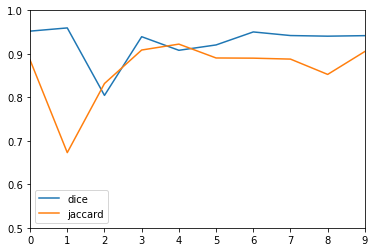

In [86]:

dice_line = plt.plot(dice,label='dice')

jaccard_line = plt.plot(jaccard,label='jaccard')

plt.axis([0,9,0.5,1])
plt.legend()
plt.show()